In [45]:
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [46]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
#from wordcloud import WordCloud
import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [47]:
tweets = pd.read_csv('train.csv')
tweets['length']=tweets['text'].str.len()
tweets['keyword'] = tweets['keyword'].str.replace('%20', ' ')
tweets['keyword'].fillna('no keyword', inplace = True)
tweets = tweets.sample(frac=1,random_state=1)
tweets_test = pd.read_csv('test.csv')

In [48]:
tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [49]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [50]:
tweets['clean_text'] = tweets['clean_text'].apply(only_letters)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [51]:
#Tokenización
from nltk.tokenize import word_tokenize
tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [52]:
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [53]:
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)

In [54]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [55]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [56]:
tweets['clean_text'] = tweets['clean_text'].apply(lemmatize_tweet)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)
tweets['clean_text'] = tweets['clean_text'].apply(lambda text:' '.join(text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))
tweets['clean_text'] = tweets['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))

In [57]:
#Nuevos features

In [58]:
def get_hashtags(s):
    return list(part[1:] for part in s.split() if part.startswith('#'))

In [59]:
tweets['hashtags'] = tweets['text'].apply(get_hashtags)

In [60]:
def hashtag_length_proportion(hashtags,length):
    return len(''.join(hashtags))/length

In [61]:
tweets['len_hash_over_text'] = tweets.apply(lambda data: hashtag_length_proportion(data['hashtags'],data['length']),axis=1)

In [62]:
def get_mentioned_users(s):
    return list(part[1:] for part in s.split() if part.startswith('@'))

In [63]:
tweets['users'] = tweets['text'].apply(get_mentioned_users)

In [64]:
def amount_hashtags(l):
    return len(l)

In [65]:
tweets['amount_hashtags']=tweets['hashtags'].apply(amount_hashtags)

In [66]:
def amount_users(l):
    return len(l)

In [67]:
def has_url(text):
    return int('http' in text)

In [68]:
tweets['has_url']=tweets['text'].apply(has_url)

In [69]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [70]:
tweets['urls']=tweets['text'].apply(find_url)
tweets['amount_urls'] = tweets['urls'].apply(lambda x: len(x))

In [71]:
tweets['amount_users']=tweets['users'].apply(amount_users)

In [72]:
tweets['keyword_encoded'] = tweets.groupby('keyword')['target'].transform('mean') #mean encoding keyword

In [73]:
tweets['len_clean_text_over_text'] =tweets['clean_text'].str.len()/tweets['length']

In [74]:
tweets.head()

,id,keyword,location,text,target,length,clean_text,hashtags,len_hash_over_text,users,amount_hashtags,has_url,urls,amount_urls,amount_users,keyword_encoded,len_clean_text_over_text
3228,4632,emergency services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1,141,goulburn man henry van bilsen missing emergenc...,[],0.0,[],0,1,[http://t.co/z99pKJzTRp],1,0,0.333333,0.638298
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0,138,thing fear organizationsfluctuations disturban...,[],0.0,[],0,0,[],0,0,0.125000,0.746377
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0,23,tsunamiesh hey esh,[],0.0,[tsunami_esh],0,0,[],0,1,0.323529,0.782609
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0,140,potus drown water entering lung alive caused g...,[],0.0,[POTUS],0,0,[],0,1,0.093750,0.571429
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\r\nThese wounds they will ...,1,51,crawling skin wound hea,[],0.0,[],0,0,[],0,0,0.303030,0.450980


In [75]:
df = tweets.drop(['text', 'clean_text','location','keyword','hashtags','users','id','target','len_hash_over_text','urls','has_url','amount_hashtags'], axis=1)
df.head()

,length,amount_urls,amount_users,keyword_encoded,len_clean_text_over_text
3228,141,1,0,0.333333,0.638298
3706,138,0,0,0.125000,0.746377
6957,23,0,1,0.323529,0.782609
2887,140,0,1,0.093750,0.571429
7464,51,0,0,0.303030,0.450980
...,...,...,...,...,...
905,121,0,0,0.085714,0.462810
5192,84,1,0,0.129032,0.488095
3980,90,1,0,0.657895,0.611111
235,73,0,0,0.323529,0.684932


In [76]:
tweets_dmatrix = xgb.DMatrix(data=df,label=tweets['target'])

In [77]:
params = {"objective":"reg:squarederror",'colsample_bytree': 1,
          'learning_rate': 0.1, 'max_depth': 6, 'alpha': 10}

cv_results = xgb.cv(dtrain=tweets_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [78]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.484206,0.000269,0.484980,0.000554
1,0.470815,0.000622,0.472389,0.000952
2,0.459462,0.000871,0.461726,0.001480
3,0.449868,0.000967,0.452689,0.002063
4,0.441842,0.001113,0.445287,0.002571


In [79]:
print((cv_results["train-rmse-mean"]).tail(1))

49    0.390757
Name: train-rmse-mean, dtype: float64


In [80]:
xg_reg = xgb.train(params=params, dtrain=tweets_dmatrix, num_boost_round=10)

In [81]:
preds = xg_reg.predict(xgb.DMatrix(df))

In [82]:
#list(preds)

In [83]:
preds = preds >=0.45 #mejor resultado que con 0.5

In [84]:
#print(list(preds))

In [85]:
f1score = f1_score(tweets['target'], preds)
print(f'Counts model score: {f1score*100}%')

Counts model score: 73.38341434673737%


In [86]:
#list(tweets['target'])

In [87]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(tweets['target'], preds)
print(confusion)

[[3315 1027]
 [ 780 2491]]


Feature importance

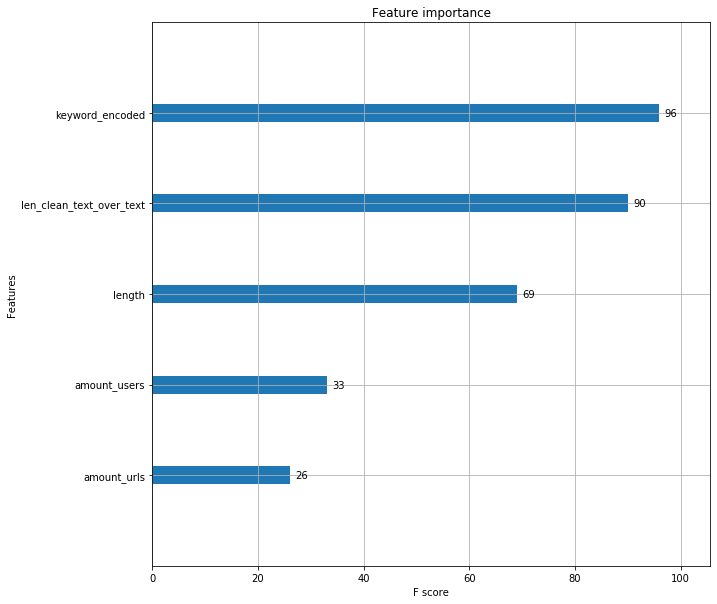

In [88]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=10, ax=ax)